In [1]:
# %matplotlib inline
import matplotlib.pyplot as plt

from typing import Callable

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import torchvision
import torchvision.transforms as transforms

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(f'{device}')

cuda


In [46]:
class AutoEncoder(nn.Module):
    
    def __init__(self, latent_filters_dim=4):
        super(AutoEncoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.MaxPool2d(2),
            nn.LeakyReLU(),
            nn.Conv2d(32, latent_filters_dim, 3, padding=1),
            nn.MaxPool2d(2),
            nn.LeakyReLU(),
#             nn.Conv2d(latent_filters_dim, latent_filters_dim, 3, padding=1),
#             nn.LeakyReLU(),
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_filters_dim, 32, 2, stride=2),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(32, 1, 2, stride=2),
            nn.Sigmoid(),
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
model = AutoEncoder()
print(model)

AutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(32, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): LeakyReLU(negative_slope=0.01)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(4, 32, kernel_size=(2, 2), stride=(2, 2))
    (1): LeakyReLU(negative_slope=0.01)
    (2): ConvTranspose2d(32, 1, kernel_size=(2, 2), stride=(2, 2))
    (3): Sigmoid()
  )
)


### Load datasets

In [4]:
class GaussianNoise(object):
    def __init__(self, mean=0., std=1., device="cpu"):
        self.mean = mean
        self.std = std
        
    def __call__(self, tensor):
        return tensor + self.mean + torch.randn(tensor.size()).to(device) * self.std
    
    def __repr__(self):
        return self.__class__.__name__ + f'(mean={self.mean}, std={self.std})'

In [5]:
transform = transforms.ToTensor()
# noisy_transform = transforms.Compose([
#     transforms.ToTensor(),
#     GaussianNoise(0., 0.25)
# ])

# MNIST
train_dataset_mnist = torchvision.datasets.MNIST(root='~/datasets', train=True, download=True, transform=transform)
test_dataset_mnist = torchvision.datasets.MNIST(root='~/datasets', train=False, download=True, transform=transform)

# Fashion MNIST
train_dataset_fashionmnist = torchvision.datasets.FashionMNIST(root='~/datasets', train=True, download=True, transform=transform)
test_dataset_fashionmnist = torchvision.datasets.FashionMNIST(root='~/datasets', train=False, download=True, transform=transform)

# Noisy MNIST
# train_dataset_noisymnist = torchvision.datasets.MNIST(root='~/datasets/noisy', train=True, download=True, transform=noisy_transform)
# test_dataset_noisymnist = torchvision.datasets.MNIST(root='~/datasets/noisy', train=False, download=True, transform=noisy_transform)

# Small MNIST
train_dataset_mnist_small = list(train_dataset_mnist)[:4096]
train_dataset_fashionmnist_small = list(train_dataset_fashionmnist)[:4096]

### Visualize images

In [6]:
def visualize_images(dataset):
    fig = plt.figure(figsize=(5, 5))
    cols, rows = 3, 3
    for i in range(1, cols * rows + 1):
        index = torch.randint(high=len(dataset), size=(1,)).item()
        image, label = dataset[index]
        fig.add_subplot(rows, cols, i)
        plt.axis("off")
        plt.imshow(image.squeeze(), cmap="gray")
    plt.show()

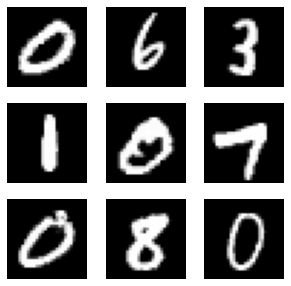

In [7]:
visualize_images(train_dataset_mnist)

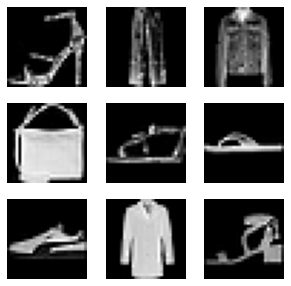

In [8]:
visualize_images(train_dataset_fashionmnist)

### Setup dataloaders and train/test functions

In [9]:
def get_dataset_loaders(train_dataset, test_dataset, batch_size=64, shuffle=True):
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle)
    return train_dataloader, test_dataloader

In [10]:
def train(
    model: nn.Module,
    device,
    train_dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    criterion: nn.Module
):
    model.train()
    train_loss = 0.0
    for batch_idx, data_batch in enumerate(train_dataloader):
        data, _ = data_batch
        data = data.to(device)
        
        # Forward pass
        recon = model(data)
        loss: torch.Tensor = criterion(recon, data)
            
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    train_loss /= len(train_dataloader.dataset)
        
    print(f'Train Loss: {train_loss}')
    return data, recon

In [11]:
def test(model, device, test_dataloader, criterion):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data_batch in test_dataloader:
            data, _ = data_batch
            data = data.to(device)
            recon = model(data)
            test_loss += criterion(recon, data).item()
    
    test_loss /= len(test_dataloader.dataset)
            
    print(f'Test loss ==>: {test_loss}')

In [12]:
def visualize_reconstruction_old(outputs, num_epochs):
    for k in range(0, num_epochs, 5):
        plt.figure(figsize=(9, 2))
        imgs = outputs[k][0].cpu().detach().numpy()
        recon = outputs[k][1].cpu().detach().numpy()
        for i, item in enumerate(imgs):
            if i >= 9: break
            plt.subplot(2, 9, i+1)
            plt.imshow(item[0], cmap="gray")

        for i, item in enumerate(recon):
            if i >= 9: break
            plt.subplot(2, 9, 9+i+1)
            plt.imshow(item[0], cmap="gray")

In [13]:
def visualize_reconstruction(outputs, num_epochs, max_col=9):
    for k in range(0, num_epochs, 5):
        plt.figure(figsize=(max_col, 2))
        imgs, recon = outputs[k]
        imgs = imgs.cpu().detach().numpy()
        recon = recon.cpu().detach().numpy()
        for i, (img, img_recon) in enumerate(zip(imgs, recon)):
            if i >= max_col: break
            plt.subplot(2, max_col, i+1)
            plt.imshow(img[0], cmap="gray")
            plt.subplot(2, max_col, max_col+i+1)
            plt.imshow(img_recon[0], cmap="gray")

### MNIST

In [14]:
# Minimize reconstruction error of autoencoder across dataset
criterion = nn.MSELoss()  

lr = 1E-3
weight_decay = 1E-5
num_epochs = 25

In [47]:
# Get dataset loaders
batch_size = 64
train_dataloader, test_dataloader = get_dataset_loaders(train_dataset_mnist_small, test_dataset_mnist, batch_size=batch_size)

In [48]:
model = AutoEncoder()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

model = model.to(device)

outputs = []
for i in range(num_epochs):
    output = train(model, device, train_dataloader, optimizer, criterion)
    outputs.append(output)
    if i % 5 == 0:
        test(model, device, test_dataloader, criterion)

Train Loss: 0.0027082606338808546
Test loss ==>: 0.0016344936333596706
Train Loss: 0.00100940170159447
Train Loss: 0.0006229325863387203
Train Loss: 0.0003492396717774682
Train Loss: 0.0002775449706859945
Train Loss: 0.00026478177733224584
Test loss ==>: 0.00025794820599257947
Train Loss: 0.00025902622428475297
Train Loss: 0.0002549809594256658
Train Loss: 0.0002518103769943991
Train Loss: 0.00024881280819499807
Train Loss: 0.0002459888246448827
Test loss ==>: 0.00024160881564021111
Train Loss: 0.0002434413377159217
Train Loss: 0.0002410140339179634
Train Loss: 0.00023883197513896448
Train Loss: 0.000236782622323517
Train Loss: 0.00023495405389439838
Test loss ==>: 0.00023118347525596619
Train Loss: 0.00023307921446757973
Train Loss: 0.00023138576489145635
Train Loss: 0.00022989794501881988
Train Loss: 0.00022840635756438132
Train Loss: 0.00022689927482133498
Test loss ==>: 0.00022344314176589252
Train Loss: 0.00022540480540556018
Train Loss: 0.00022416471983888187
Train Loss: 0.000222

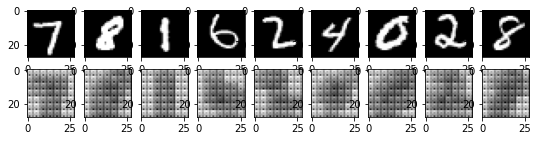

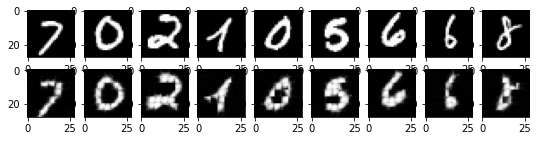

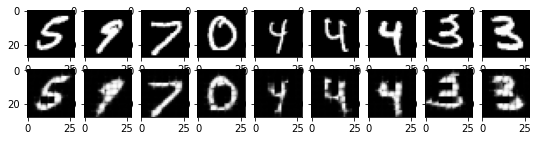

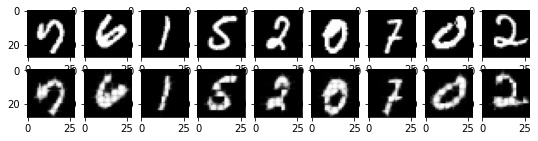

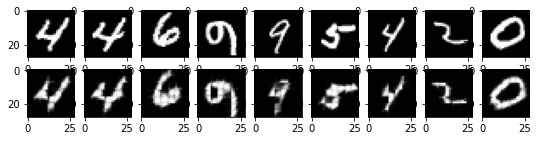

In [49]:
visualize_reconstruction(outputs, num_epochs)

#### Run the same model using a smaller amount of training data

In [18]:
# Get smaller dataset
batch_size = 64
train_dataloader, test_dataloader = get_dataset_loaders(train_dataset_mnist, test_dataset_mnist, batch_size=batch_size)

In [19]:
model = AutoEncoder()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

model = model.to(device)

outputs = []
for i in range(num_epochs):
    output = train(model, device, train_dataloader, optimizer, criterion)
    outputs.append(output)
    if i % 5 == 0:
        test(model, device, test_dataloader, criterion)

Train Loss: 0.0006781511762489875
Test loss ==>: 0.00026892900820821525
Train Loss: 0.00024794128661354383
Train Loss: 0.00022234424877290925
Train Loss: 0.00020750749587702255
Train Loss: 0.00019625723261075715
Train Loss: 0.00018584584834364554
Test loss ==>: 0.00017627857429906727
Train Loss: 0.00017479962914561232
Train Loss: 0.00016595691251568496
Train Loss: 0.00016004302132253845
Train Loss: 0.00015593325099907816
Train Loss: 0.00015280480575747787
Test loss ==>: 0.00014797649774700404
Train Loss: 0.0001503096752334386
Train Loss: 0.00014832395798681925
Train Loss: 0.00014672880788178493
Train Loss: 0.00014541000129344563
Train Loss: 0.00014421410713500032
Test loss ==>: 0.0001410104409791529
Train Loss: 0.00014323146751460929
Train Loss: 0.00014236402008682488
Train Loss: 0.00014165834323503077
Train Loss: 0.00014098847227481505
Train Loss: 0.00014040070466386775
Test loss ==>: 0.00013612142545171081
Train Loss: 0.00013988911748553316
Train Loss: 0.00013949163056289156
Train Lo

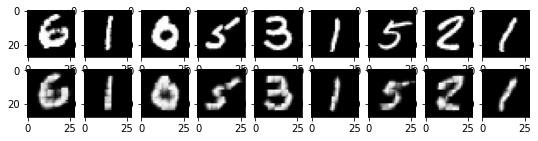

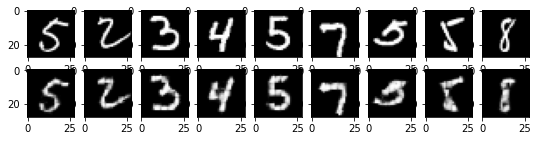

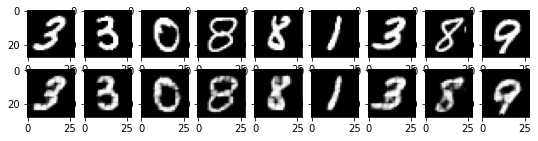

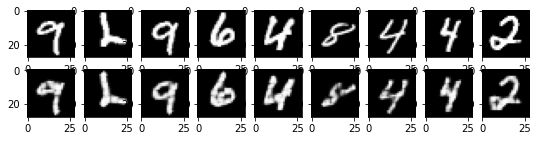

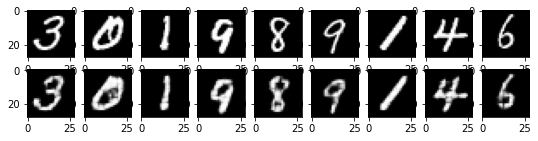

In [20]:
visualize_reconstruction(outputs, num_epochs)

### Fashion MNIST

In [21]:
# Get dataset loaders
batch_size = 64
train_dataloader, test_dataloader = get_dataset_loaders(train_dataset_fashionmnist, test_dataset_fashionmnist, batch_size=batch_size, shuffle=False)

In [22]:
model = AutoEncoder()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

model = model.to(device)

outputs = []
for i in range(num_epochs):
    output = train(model, device, train_dataloader, optimizer, criterion)
    outputs.append(output)
    if i % 5 == 0:
        test(model, device, test_dataloader, criterion)

Train Loss: 0.00046716103451326487
Test loss ==>: 0.00025377360014244913
Train Loss: 0.00023071297466134032
Train Loss: 0.00020833892848653098
Train Loss: 0.0001961440335959196
Train Loss: 0.00018736847777230044
Train Loss: 0.00018088532794887822
Test loss ==>: 0.00018066100720316172
Train Loss: 0.00017579487801219027
Train Loss: 0.00017079804254074892
Train Loss: 0.00016721370389374593
Train Loss: 0.00016470419876277447
Train Loss: 0.00016254178513772785
Test loss ==>: 0.00016383444126695396
Train Loss: 0.00016061695998845002
Train Loss: 0.00015891771581955254
Train Loss: 0.00015724621793876092
Train Loss: 0.00015515166193557283
Train Loss: 0.00015297641019181658
Test loss ==>: 0.00015386600168421864
Train Loss: 0.00015131208122087022
Train Loss: 0.0001501246161138018
Train Loss: 0.00014918786290412148
Train Loss: 0.00014841738749916356
Train Loss: 0.00014775077922580144
Test loss ==>: 0.00014928124235011637
Train Loss: 0.0001471555949964871
Train Loss: 0.00014661772961262613
Train Lo

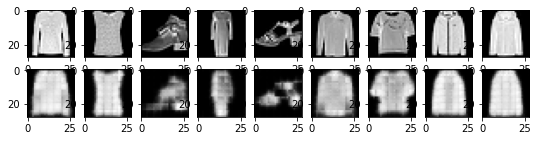

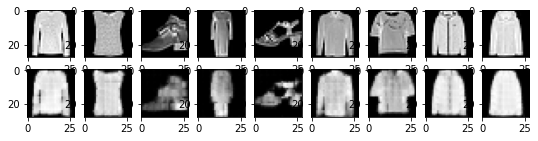

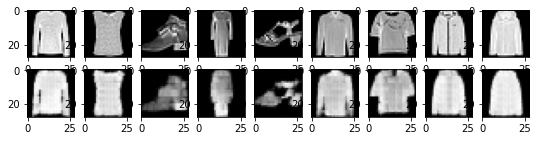

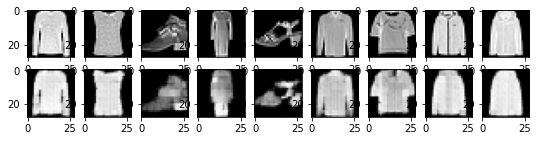

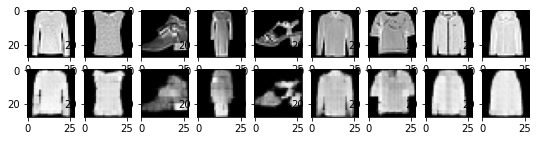

In [23]:
visualize_reconstruction(outputs, num_epochs)

### Noisy MNIST

In [24]:
num_epochs = 20

In [25]:
# Get dataset loaders
batch_size = 64
train_dataloader, test_dataloader = get_dataset_loaders(train_dataset_mnist, test_dataset_mnist, batch_size=batch_size)

In [26]:
def train_noisy(
    model: nn.Module,
    device,
    train_dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    criterion: nn.Module,
    noise_func: Callable
):
    """
    :param noise_func: Callable that adds noise to a batch of images
    """
    model.train()
    train_loss = 0.0
    for batch_idx, data_batch in enumerate(train_dataloader):
        clean, _ = data_batch
        clean = clean.to(device)
                
        # Forward pass
        noisy = noise_func(clean)
        recon = model(noisy)
        loss: torch.Tensor = criterion(recon, clean)
            
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    train_loss /= len(train_dataloader.dataset)
        
    print(f'Loss: {train_loss}')
    return clean, noisy, recon

In [27]:
def visualize_reconstruction_noisy(outputs, num_epochs):
    for k in range(0, num_epochs, 5):
        plt.figure(figsize=(9, 3))
        clean, noisy, recon = outputs[k]
        clean = clean.cpu().detach().numpy()
        noisy = noisy.cpu().detach().numpy()
        recon = recon.cpu().detach().numpy()
        for i, item in enumerate(clean):
            if i >= 9: break
            plt.subplot(3, 9, i+1)
            plt.imshow(item[0], cmap="gray")
            
        for i, item in enumerate(noisy):
            if i >= 9: break
            plt.subplot(3, 9, 9+i+1)
            plt.imshow(item[0], cmap="gray")

        for i, item in enumerate(recon):
            if i >= 9: break
            plt.subplot(3, 9, 18+i+1)
            plt.imshow(item[0], cmap="gray")

In [28]:
def visualize_reconstruction_noisy(outputs, num_epochs, max_col=9):
    for k in range(0, num_epochs, 5):
        plt.figure(figsize=(max_col, 3))
        imgs_clean, imgs_noisy, imgs_recon = outputs[k]
        imgs_clean = imgs_clean.cpu().detach().numpy()
        imgs_noisy = imgs_noisy.cpu().detach().numpy()
        imgs_recon = imgs_recon.cpu().detach().numpy()
        for i, (img_clean, img_noisy, img_recon) in enumerate(zip(imgs_clean, imgs_noisy, imgs_recon)):
            if i >= max_col: break
            plt.subplot(3, max_col, i+1)
            plt.imshow(img_clean[0], cmap="gray")
            plt.subplot(3, max_col, max_col+i+1)
            plt.imshow(img_noisy[0], cmap="gray")
            plt.subplot(3, max_col, 2*max_col+i+1)
            plt.imshow(img_recon[0], cmap="gray")

In [29]:
model = AutoEncoder()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

noise_func = GaussianNoise(device=device)

model = model.to(device)

outputs = []
for i in range(num_epochs):
    output = train_noisy(model, device, train_dataloader, optimizer, criterion, noise_func)
    outputs.append(output)
    if i % 5 == 0:
        test(model, device, test_dataloader, criterion)

Loss: 0.0009681988002111514
Test loss ==>: 0.0005388451009988785
Loss: 0.0006507852472985784
Loss: 0.0006324329840019346
Loss: 0.0006221479809532563
Loss: 0.0006164740232750774
Loss: 0.0006105745149155458
Test loss ==>: 0.00047517640981823204
Loss: 0.0006060325686509411
Loss: 0.0006031105324625969
Loss: 0.000601285749177138
Loss: 0.0005970671402911346
Loss: 0.0005949833896011115
Test loss ==>: 0.00040004378277808426
Loss: 0.0005919034712016583
Loss: 0.0005901043891906739
Loss: 0.0005882067050784827
Loss: 0.0005862811720619599
Loss: 0.0005859965384627382
Test loss ==>: 0.00037049786429852247
Loss: 0.0005833502698689699
Loss: 0.0005829929038261374
Loss: 0.0005817675348371267
Loss: 0.0005811394683395823


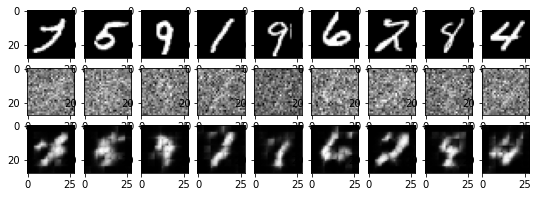

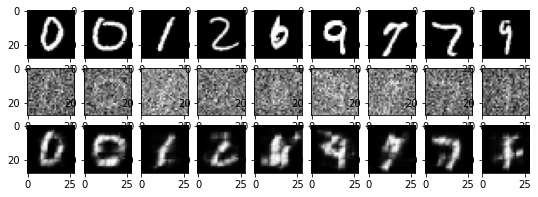

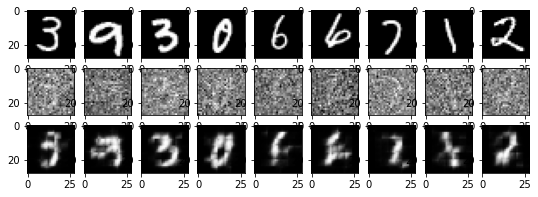

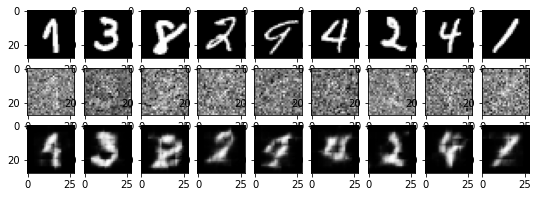

In [30]:
visualize_reconstruction_noisy(outputs, num_epochs)

Loss: 0.0007244523556592564
Test loss ==>: 0.00032016472723335026
Loss: 0.0005166772763244808
Loss: 0.0004946083595976234
Loss: 0.0004829463559823732
Loss: 0.00047529232883825897
Loss: 0.000469360880057017
Test loss ==>: 0.00024320257026702165
Loss: 0.00046646210572992764
Loss: 0.00046241556257009504
Loss: 0.0004617689512980481
Loss: 0.00046005181536699333
Loss: 0.0004585511694041391
Test loss ==>: 0.00020967855025082825
Loss: 0.0004568841849764188
Loss: 0.0004554256445107361
Loss: 0.00045567103180413446
Loss: 0.0004546783302600185
Loss: 0.0004542758807850381
Test loss ==>: 0.00021135735772550107
Loss: 0.0004530123152770102
Loss: 0.0004531907107991477
Loss: 0.0004526498002621035
Loss: 0.00045208818713823954


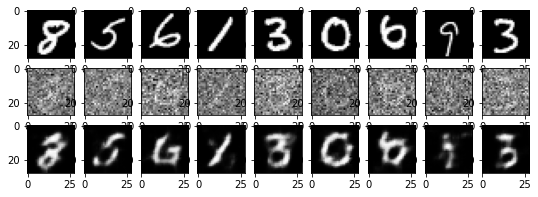

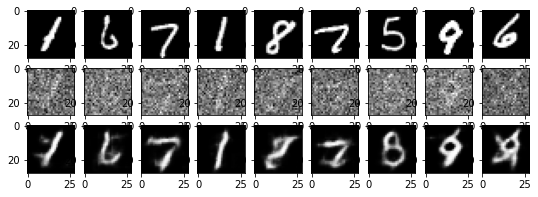

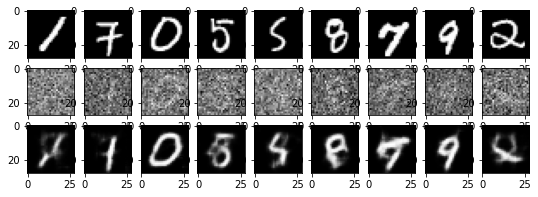

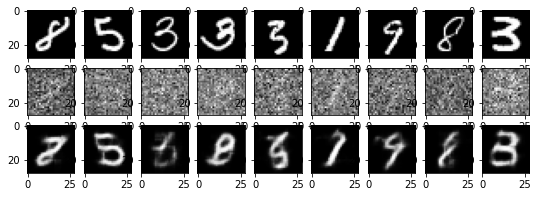

In [31]:
model = AutoEncoder(32)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

noise_func = GaussianNoise(device=device)

model = model.to(device)

outputs = []
for i in range(num_epochs):
    output = train_noisy(model, device, train_dataloader, optimizer, criterion, noise_func)
    outputs.append(output)
    if i % 5 == 0:
        test(model, device, test_dataloader, criterion)
        
visualize_reconstruction_noisy(outputs, num_epochs)

#### Gaussian Noise with $\sigma=0.5$

Loss: 0.0009802449294676384
Test loss ==>: 0.0004778726413846016
Loss: 0.0004024565868390103
Loss: 0.00035693766931071876
Loss: 0.00034061683878923454
Loss: 0.0003305496694520116
Loss: 0.0003239707517127196
Test loss ==>: 0.0002429303452372551
Loss: 0.0003197010641917586
Loss: 0.0003163406567958494
Loss: 0.0003136694476318856
Loss: 0.00031185853021840253
Loss: 0.000310169171107312
Test loss ==>: 0.00022928319349884986
Loss: 0.00030880945151050884
Loss: 0.00030701518300920724
Loss: 0.0003055479944994052
Loss: 0.0003034624054717521
Loss: 0.00030182005433986584
Test loss ==>: 0.00020721470937132836
Loss: 0.0003008703572054704
Loss: 0.0003003893076131741
Loss: 0.00029983263708030185
Loss: 0.0002994450591194133


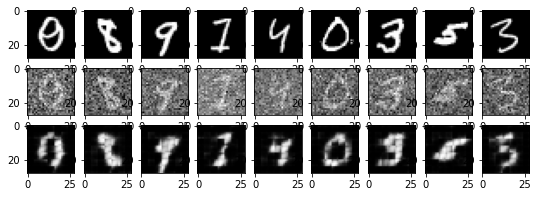

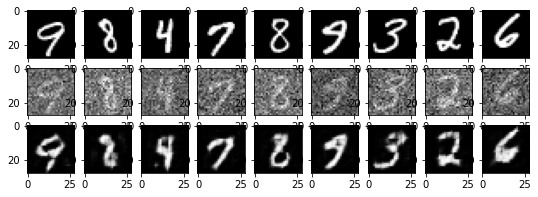

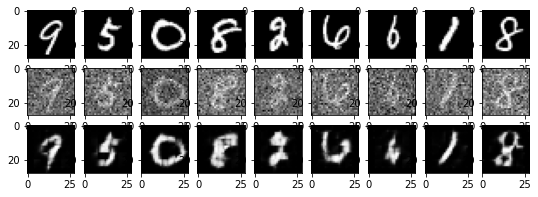

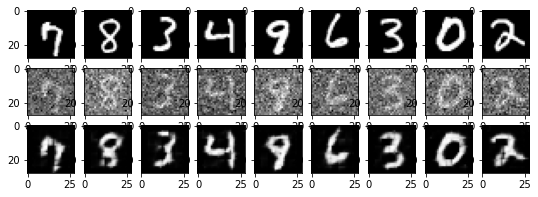

In [32]:
model = AutoEncoder()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

noise_func = GaussianNoise(std=0.5, device=device)

model = model.to(device)

outputs = []
for i in range(num_epochs):
    output = train_noisy(model, device, train_dataloader, optimizer, criterion, noise_func)
    outputs.append(output)
    if i % 5 == 0:
        test(model, device, test_dataloader, criterion)
        
visualize_reconstruction_noisy(outputs, num_epochs)

#### Gaussian Noise with $\sigma=0.25$

Loss: 0.0018174442232896885
Test loss ==>: 0.0017950725384056569
Loss: 0.0017476693883538247
Loss: 0.000535901960885773
Loss: 0.00027817725936571755
Loss: 0.0002560303443111479
Loss: 0.0002456340386377027
Test loss ==>: 0.00020366701129823924
Loss: 0.0002391229371385028
Loss: 0.0002339293277822435
Loss: 0.0002294335008598864
Loss: 0.00022590756610346336
Loss: 0.0002228297337113569
Test loss ==>: 0.00018089296650141478
Loss: 0.00022029681770751873
Loss: 0.0002177043620341768
Loss: 0.00021562810560377935
Loss: 0.00021338566436121862
Loss: 0.00021116165020503103
Test loss ==>: 0.00016989646945148707
Loss: 0.00020952443528609972
Loss: 0.00020779435972993572
Loss: 0.00020574646277042726
Loss: 0.00020376185229979455


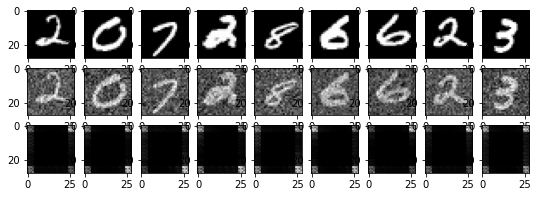

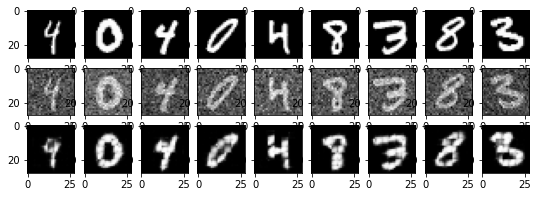

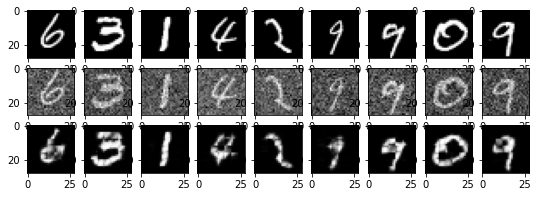

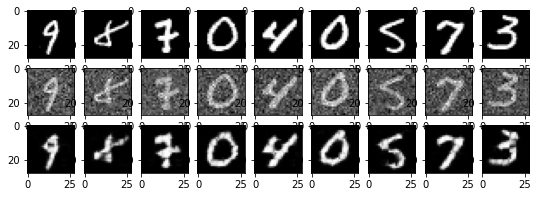

In [33]:
model = AutoEncoder()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

noise_func = GaussianNoise(std=0.25, device=device)

model = model.to(device)

outputs = []
for i in range(num_epochs):
    output = train_noisy(model, device, train_dataloader, optimizer, criterion, noise_func)
    outputs.append(output)
    if i % 5 == 0:
        test(model, device, test_dataloader, criterion)
        
visualize_reconstruction_noisy(outputs, num_epochs)

Loss: 0.0003266201374741892
Test loss ==>: 8.78340670838952e-05
Loss: 0.00011434274336012702
Loss: 0.00010314588491649677
Loss: 9.800038534061362e-05
Loss: 9.518928761438778e-05
Loss: 9.326637322083115e-05
Test loss ==>: 5.5676761688664554e-05
Loss: 9.17685416371872e-05
Loss: 9.070020099170506e-05
Loss: 8.988039722510924e-05
Loss: 8.91449337049077e-05
Loss: 8.86065465087692e-05
Test loss ==>: 5.233731404878199e-05
Loss: 8.79171268393596e-05
Loss: 8.762468167891105e-05
Loss: 8.697365774617841e-05
Loss: 8.691013331214587e-05
Loss: 8.645553161234906e-05
Test loss ==>: 5.071463426575065e-05
Loss: 8.597080703669538e-05
Loss: 8.568870550176749e-05
Loss: 8.515573996895304e-05
Loss: 8.496473792474717e-05


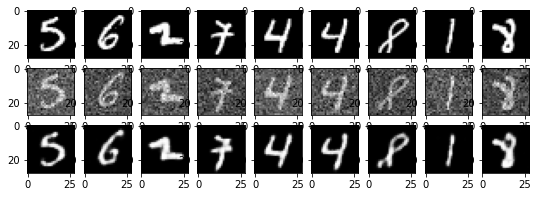

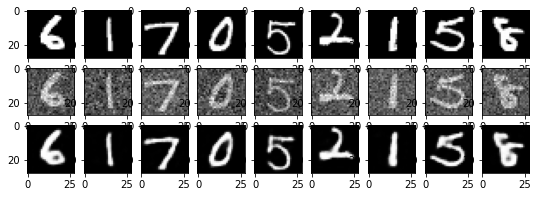

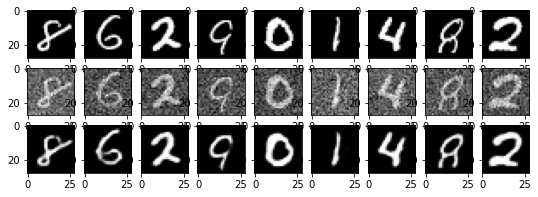

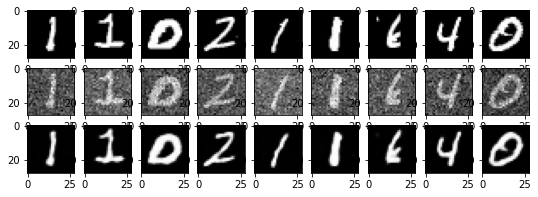

In [34]:
model = AutoEncoder(16)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

noise_func = GaussianNoise(std=0.25, device=device)

model = model.to(device)

outputs = []
for i in range(num_epochs):
    output = train_noisy(model, device, train_dataloader, optimizer, criterion, noise_func)
    outputs.append(output)
    if i % 5 == 0:
        test(model, device, test_dataloader, criterion)
        
visualize_reconstruction_noisy(outputs, num_epochs)

### Noisy FashionMNIST

In [35]:
num_epochs = 25

In [36]:
# Get dataset loaders
batch_size = 64
train_dataloader, test_dataloader = get_dataset_loaders(train_dataset_fashionmnist_small, test_dataset_mnist, batch_size=batch_size)

Loss: 0.0022952531107875984
Test loss ==>: 0.0030718844175338746
Loss: 0.00129930583989335
Loss: 0.0008309891754834098
Loss: 0.0007897163804955198
Loss: 0.0007554653557235724
Loss: 0.0007102834297256777
Test loss ==>: 0.001825674571841955
Loss: 0.0006631928581555258
Loss: 0.0006380304430422257
Loss: 0.0006257953673411976
Loss: 0.000618053798461915
Loss: 0.0006168544259708142
Test loss ==>: 0.0008117005221545696
Loss: 0.0006107800754762138
Loss: 0.0006096119677749812
Loss: 0.0006048391587683
Loss: 0.0006022547022439539
Loss: 0.0005995575329507119
Test loss ==>: 0.000720414486899972
Loss: 0.0006010728393448517
Loss: 0.0005954981170361862
Loss: 0.0005934940963925328
Loss: 0.0005931215455348138
Loss: 0.0005902444963794551
Test loss ==>: 0.000705062323436141
Loss: 0.0005874949456483591
Loss: 0.0005882097802896169
Loss: 0.0005890441925657797
Loss: 0.0005852608146597049


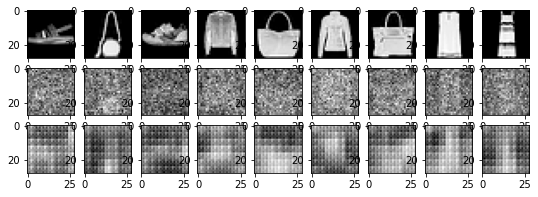

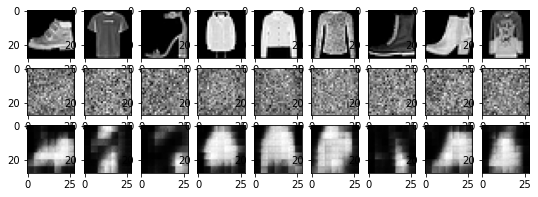

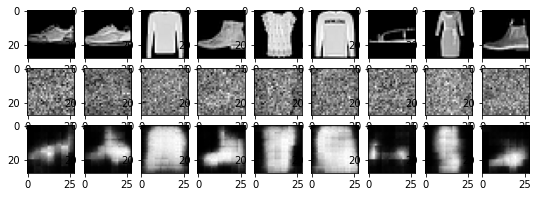

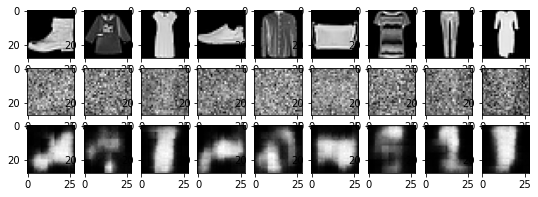

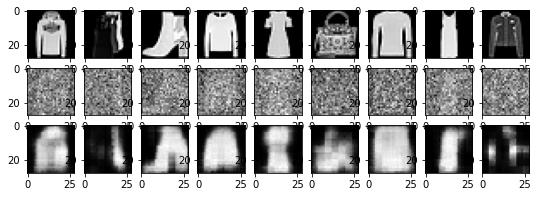

In [37]:
model = AutoEncoder()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

noise_func = GaussianNoise(device=device)

model = model.to(device)

outputs = []
for i in range(num_epochs):
    output = train_noisy(model, device, train_dataloader, optimizer, criterion, noise_func)
    outputs.append(output)
    if i % 5 == 0:
        test(model, device, test_dataloader, criterion)
        
visualize_reconstruction_noisy(outputs, num_epochs)

Loss: 0.0019015512480109464
Test loss ==>: 0.0011673568278551102
Loss: 0.0009960837314793025
Loss: 0.0006525122207676759
Loss: 0.00043670453942468157
Loss: 0.00039259237610167474
Loss: 0.0003692947570925753
Test loss ==>: 0.0005296630112454295
Loss: 0.0003500717753013305
Loss: 0.0003362498387105006
Loss: 0.0003250464951634058
Loss: 0.00031522868948741234
Loss: 0.0003070464599659317
Test loss ==>: 0.00045850718207657336
Loss: 0.00029980540875840234
Loss: 0.0002929588349616097
Loss: 0.0002876351072700345
Loss: 0.0002817699878505664
Loss: 0.0002769917086880014
Test loss ==>: 0.00041756182201206686
Loss: 0.00027254559836364933
Loss: 0.0002683995624011004
Loss: 0.0002650297612944996
Loss: 0.0002616409624351945
Loss: 0.00025865262955449
Test loss ==>: 0.0003823376551270485
Loss: 0.00025545275298100023
Loss: 0.00025305369945272105
Loss: 0.0002504217095520289
Loss: 0.0002480669147644221


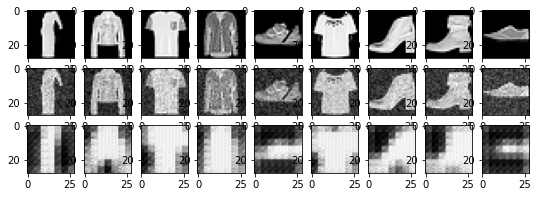

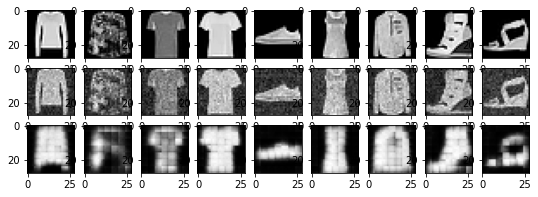

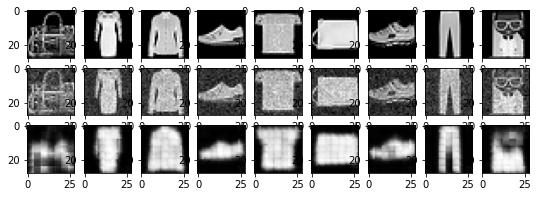

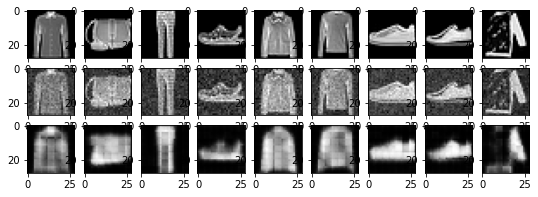

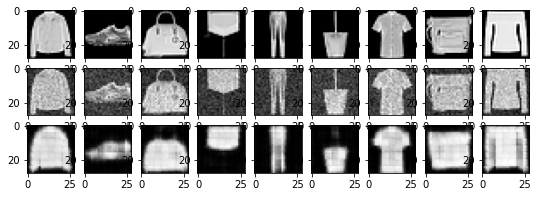

In [38]:
model = AutoEncoder()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

noise_func = GaussianNoise(std=0.1, device=device)

model = model.to(device)

outputs = []
for i in range(num_epochs):
    output = train_noisy(model, device, train_dataloader, optimizer, criterion, noise_func)
    outputs.append(output)
    if i % 5 == 0:
        test(model, device, test_dataloader, criterion)
        
visualize_reconstruction_noisy(outputs, num_epochs)

Loss: 0.0018543199121268117
Test loss ==>: 0.000977742938324809
Loss: 0.0008054757745412644
Loss: 0.0005698662239410623
Loss: 0.00039692664040558157
Loss: 0.0003314431742182933
Loss: 0.00030413445483645773
Test loss ==>: 0.0004877982484176755
Loss: 0.00028544617862280575
Loss: 0.00027054550218963413
Loss: 0.0002590570820757421
Loss: 0.00024931984421527886
Loss: 0.00023996111121959984
Test loss ==>: 0.00037465980425477026
Loss: 0.000231934084013119
Loss: 0.0002247619559057057
Loss: 0.0002182941075261624
Loss: 0.00021281567319419992
Loss: 0.0002079838052395644
Test loss ==>: 0.00031718423292040825
Loss: 0.0002034244434980792
Loss: 0.00019946816678384494
Loss: 0.0001965164701687172
Loss: 0.00019282509560980543
Loss: 0.00019035035461456573
Test loss ==>: 0.0002808006215840578
Loss: 0.00018761969522529398
Loss: 0.00018518856654736737
Loss: 0.0001824884104735247
Loss: 0.00018044313901555142


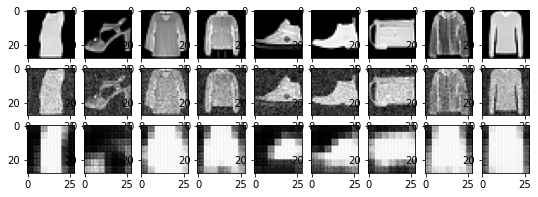

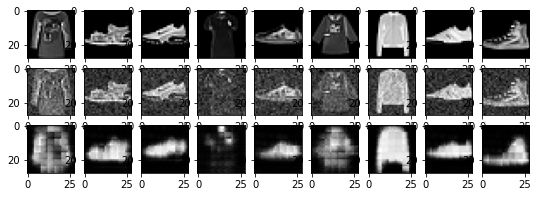

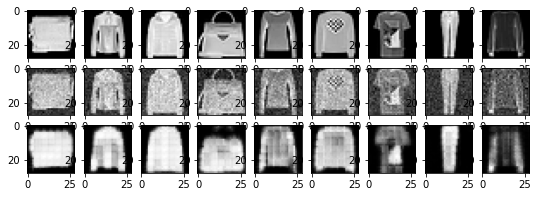

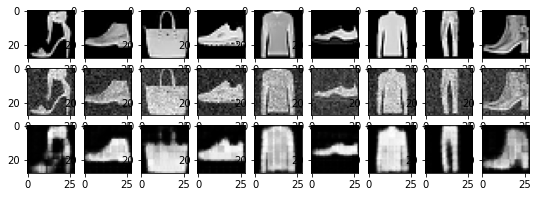

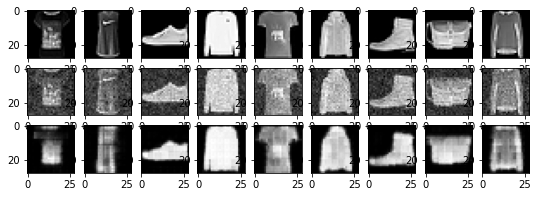

In [39]:
model = AutoEncoder(8)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

noise_func = GaussianNoise(std=0.1, device=device)

model = model.to(device)

outputs = []
for i in range(num_epochs):
    output = train_noisy(model, device, train_dataloader, optimizer, criterion, noise_func)
    outputs.append(output)
    if i % 5 == 0:
        test(model, device, test_dataloader, criterion)
        
visualize_reconstruction_noisy(outputs, num_epochs)

### New AutoEncoder with better interpolation

In [40]:
class AutoEncoderWithInterp(nn.Module):
    
    def __init__(self, latent_dim_filters=4):
        super(AutoEncoderWithInterp, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, latent_dim_filters, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(latent_dim_filters, latent_dim_filters, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(latent_dim_filters + latent_dim_filters, 32, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(32 + 32, 1, kernel_size=3, padding=1)
        
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.maxpool = nn.MaxPool2d(2)
        self.lrelu = nn.LeakyReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # encoder
        x1 = self.conv1(x)                 # 28 x 28
        x2 = self.lrelu(self.maxpool(x1))  # 14 x 14
        x2 = self.conv2(x2)
        x3 = self.lrelu(self.maxpool(x2))  # 7 x 7
        x3 = self.conv3(x3)
        x3 = self.lrelu(x3)  # 7 x 7
        
        # decoder
        x = self.upsample(x3)  # 14 x 14
        x = self.conv4(torch.cat([x2, x], dim=1))
        x = self.lrelu(x)
        x = self.upsample(x)
        x = self.conv5(torch.cat([x1, x], dim=1))
        x = self.sigmoid(x)
        
        return x
    
model_with_interp = AutoEncoderWithInterp()
print(model_with_interp)

AutoEncoderWithInterp(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(8, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (upsample): Upsample(scale_factor=2.0, mode=bilinear)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lrelu): LeakyReLU(negative_slope=0.01)
  (sigmoid): Sigmoid()
)


In [51]:
# Get dataset loaders
batch_size = 64
train_dataloader, test_dataloader = get_dataset_loaders(train_dataset_fashionmnist, test_dataset_mnist, batch_size=batch_size)

Loss: 0.0003302941249683499
Test loss ==>: 0.0002459654793143272
Loss: 0.00026499040491568545
Loss: 0.0002545568256483724
Test loss ==>: 0.00026025132099166513
Loss: 0.00024919155874910455
Loss: 0.00024520841546667117
Test loss ==>: 0.0002613012722693384
Loss: 0.0002430190126411617
Loss: 0.00024099140491647025
Test loss ==>: 0.00024814480813220146
Loss: 0.00023900469184542697
Loss: 0.0002376069198983411
Test loss ==>: 0.0002482220998965204
Loss: 0.0002364994558505714
Loss: 0.0002357844524240742
Test loss ==>: 0.0002284145458601415
Loss: 0.00023520251784163218
Loss: 0.00023440788290463388
Test loss ==>: 0.00026096185836941004
Loss: 0.0002336939221403251
Loss: 0.00023363264586466053
Test loss ==>: 0.00024078435441479088
Loss: 0.00023322879276238383
Loss: 0.00023283500152950485
Test loss ==>: 0.00024199144942685963
Loss: 0.00023241713790533443
Loss: 0.00023206526935100555
Test loss ==>: 0.0002588406966999173
Loss: 0.00023176565103543302
Loss: 0.00023159507430779437
Test loss ==>: 0.000262

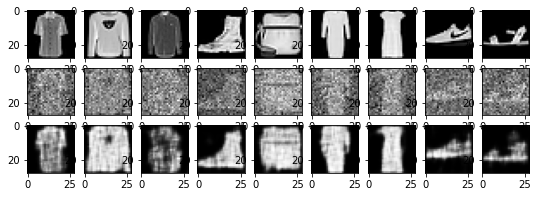

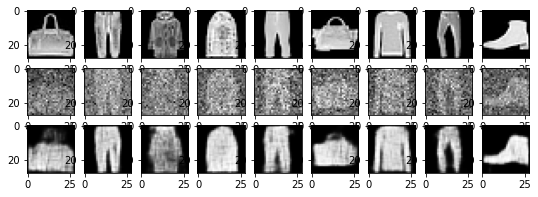

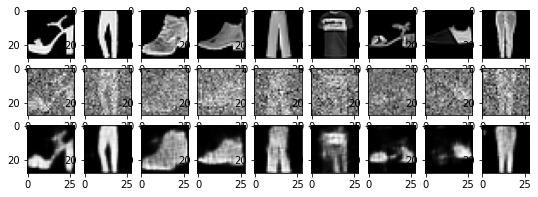

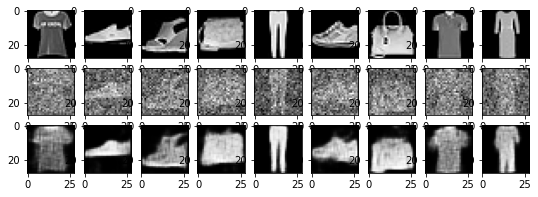

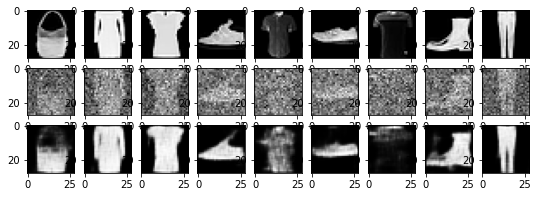

In [42]:
model = AutoEncoderWithInterp()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

noise_func = GaussianNoise(device=device, std=0.5)

model = model.to(device)

outputs = []
for i in range(num_epochs):
    output = train_noisy(model, device, train_dataloader, optimizer, criterion, noise_func)
    outputs.append(output)
    if i % 2 == 0:
        test(model, device, test_dataloader, criterion)
        
visualize_reconstruction_noisy(outputs, num_epochs)

Loss: 0.00020103456640305618
Test loss ==>: 7.91995610576123e-05
Loss: 0.0001392720574901129
Loss: 0.00013142929245562603
Test loss ==>: 6.617722022347153e-05
Loss: 0.00012724323561415075
Loss: 0.00012453532530150066
Test loss ==>: 6.4258949062787e-05
Loss: 0.00012280718290712684
Loss: 0.00012153410744698098
Test loss ==>: 6.559432670474053e-05
Loss: 0.00012041252302781989
Loss: 0.00011963049112043033
Test loss ==>: 5.616952069103718e-05
Loss: 0.00011890833561774343
Loss: 0.00011826175095823905
Test loss ==>: 5.8068633684888485e-05
Loss: 0.00011759455745729307
Loss: 0.00011711254583206028
Test loss ==>: 5.526368331629783e-05
Loss: 0.00011672050065050522
Loss: 0.00011641844563030948
Test loss ==>: 5.77388176927343e-05
Loss: 0.00011602199464881171
Loss: 0.00011587278800240407
Test loss ==>: 5.61153685906902e-05
Loss: 0.00011557165265548975
Loss: 0.0001154588860226795
Test loss ==>: 6.015372020192444e-05
Loss: 0.00011521030852260689
Loss: 0.00011501542689123502
Test loss ==>: 6.1228019720

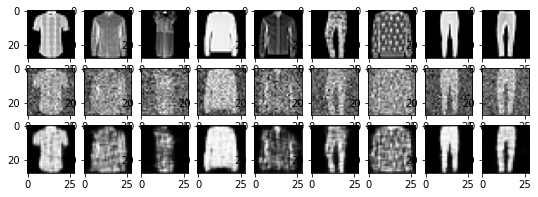

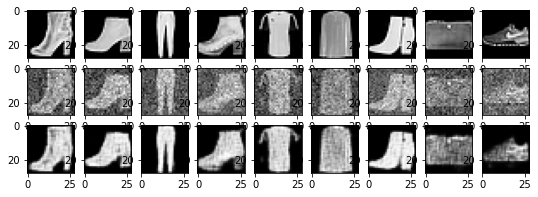

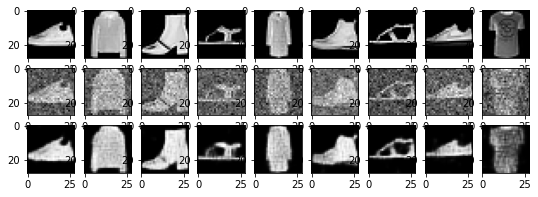

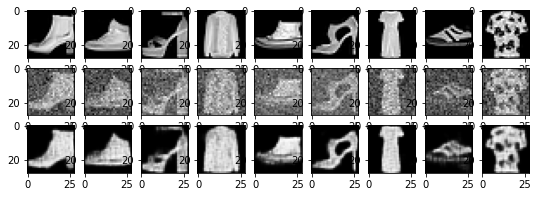

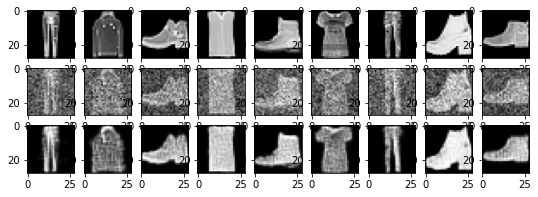

In [52]:
model = AutoEncoderWithInterp()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

noise_func = GaussianNoise(device=device, std=0.25)

model = model.to(device)

outputs = []
for i in range(num_epochs):
    output = train_noisy(model, device, train_dataloader, optimizer, criterion, noise_func)
    outputs.append(output)
    if i % 2 == 0:
        test(model, device, test_dataloader, criterion)
        
visualize_reconstruction_noisy(outputs, num_epochs)

In [43]:
class NoisyDataset(Dataset):
    def __init__(self, clean_dataset, clean_transform=None, noisy_transform=None):
        self.clean_dataset = clean_dataset
        self.clean_transform = clean_transform
        self.noisy_transform = noisy_transform
        
    def __len__(self):
        return len(self.clean_dataset)
    
    def __getitem__(self, idx):
        clean = self.clean_dataset[idx]
        
        print(f"{clean}")
        
        if self.clean_transform != None:
            clean=self.clean_transform(clean)
            
        if self.noisy_transform != None:
            noisy=self.noisy_transform(noisy)
            
        return clean, noisy

In [44]:
# noisy_transform = transforms.Compose([
#     transforms.ToTensor(),
#     GaussianNoise(0., 0.25)
# ])

train_dataset_noisy_mnist = NoisyDataset(train_dataset_mnist.data, clean_transform=transform, noisy_transform=noisy_transform)
test_dataset_noisy_mnist = NoisyDataset(test_dataset_mnist.data, clean_transform=transform, noisy_transform=noisy_transform)

# Get dataset loaders
batch_size = 64
train_dataloader, test_dataloader = get_dataset_loaders(train_dataset_noisy_mnist, test_dataset_noisy_mnist, batch_size=batch_size, shuffle=True)

NameError: name 'noisy_transform' is not defined